In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

images = glob.glob('*/*/*.png')
# images for training, GTI vehicle set are pre-separated to prevent overfitting
cars_train = []
# images for testing
cars_test = []
notcars = []
for image in images:
    if '_test' in image:
        cars_test.append(image)
    elif '_train' in image:
        cars_train.append(image)
    else:
        notcars.append(image)

# split notcars into training and test subsets
rand_state = np.random.randint(0, 100)
notcars_train, notcars_test, y_train, y_test = train_test_split(
    notcars, np.ones(len(notcars)), test_size = 0.2, random_state = rand_state) 

# record data features
cars_train_num = len(cars_train)
cars_test_num = len(cars_test)
notcars_train_num = len(notcars_train)
notcars_test_num = len(notcars_test)

In [2]:
# define a function to compute spatial features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis = False, feature_vec = True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    # concatenate all histograms into one feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace = 'RGB', spatial_size = (32, 32), 
                     hist_bins = 32, hist_range = (0, 256), orient = 9, 
                     pix_per_cell = 8, cell_per_block = 2, hog_channel = 0):
    features = [];
    # iterate over every image
    for img in imgs:
        # image in BGR colorspace, needs to be converted to requested colorspace  
        image = cv2.imread(img)
        if cspace != 'RGB':
            if cspace == 'HSV':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'LAB':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # extract spatial features
        spatial_features = bin_spatial(image, spatial_size)
        # extract hist features
        hist_features = color_hist(image, hist_bins, hist_range)
        # extract hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(image.shape[2]):
                hog_features.append(get_hog_features(image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(
                image[:,:,hog_channel], orient, pix_per_cell, 
                cell_per_block, vis=False, feature_vec=True)
        # combine features    
        combined_features = np.concatenate([spatial_features, hist_features, hog_features])
        features.append(combined_features)    
    return features       

In [3]:
# extract features for each subset of data
colorspace = 'LAB'
spatial = 32
histbins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

cars_train_features = extract_features(cars_train, cspace = colorspace, spatial_size = (spatial, spatial), 
                                       hist_bins = histbins, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, hog_channel=hog_channel)
cars_test_features = extract_features(cars_test, cspace = colorspace, spatial_size = (spatial, spatial), 
                                      hist_bins = histbins, orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, hog_channel=hog_channel)
notcars_train_features = extract_features(notcars_train, cspace = colorspace, spatial_size = (spatial, spatial), 
                                          hist_bins = histbins, orient=orient, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block, hog_channel=hog_channel)
notcars_test_features = extract_features(notcars_test, cspace = colorspace, spatial_size = (spatial, spatial), 
                                         hist_bins = histbins, orient=orient, pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, hog_channel=hog_channel)

C:\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [4]:
image = cv2.imread(cars_train[0])
print (cars_train_features[0].shape)

(8460,)


In [5]:
# Create an array stack of feature vectors
X = np.vstack((cars_train_features, notcars_train_features, cars_test_features, notcars_test_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler()
X_scaler.fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [6]:
# split into trainning and testing subsets
X_train = scaled_X[0:(cars_train_num + notcars_train_num)]
X_test = scaled_X[(cars_train_num + notcars_train_num):]
# create the label vector
y_train = np.hstack((np.ones(cars_train_num), np.zeros(notcars_train_num)))
y_test = np.hstack((np.ones(cars_test_num), np.zeros(notcars_test_num)))
# shuffle the data
rand_state = np.random.randint(0, 100)
X_train, y_train = shuffle(X_train, y_train, random_state = rand_state)
X_test, y_test = shuffle(X_test, y_test, random_state = rand_state)

In [7]:
# create a state vector machine
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 
#              'gamma':(0.1, 0.5, 1)}
#svc = SVC()
#clf = GridSearchCV(svc, parameters)
clf = SVC(kernel = 'rbf')
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
# output accuracy 
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)

In [8]:
print (accuracy_train)
print (accuracy_test)

0.999792960663
0.974923547401


In [47]:
# search cars within a frame
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    # convert colorspace
    box_list = []
    draw_image = np.copy(img)
    image = cv2.cvtColor(img[ystart:ystop,:,:], cv2.COLOR_RGB2LAB)
    # rescale the image
    shape = image.shape
    image = cv2.resize(image, (np.int(shape[1] / scale), np.int(shape[0] / scale)))
    # split the image into different color channels
    ch1 = image[:,:,0]
    ch2 = image[:,:,1]
    ch3 = image[:,:,2]
    # extract hog feature from each channel
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
    nxcells = ch1.shape[1] // pix_per_cell
    nycells = ch1.shape[0] // pix_per_cell
    # sample window size set to 64
    window = 64
    cells_per_step = 2
    cells_per_window = window // pix_per_cell
    nblocks_per_window = cells_per_window - cell_per_block + 1
    nxsteps = (nxcells - cells_per_window) // cells_per_step + 1
    nysteps = (nycells - cells_per_window) // cells_per_step + 1
    for nx in range(nxsteps):
        for ny in range(nysteps):
            xpos = nx * cells_per_step
            ypos = ny * cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            # Take a subimage of size 64
            subimage = image[ytop:ytop + window, xleft:xleft + window]
            subimage = cv2.resize(subimage, (64, 64))
            spatial_features = bin_spatial(subimage, spatial_size)
            hist_features = color_hist(subimage, hist_bins)
            test_features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_scaled = X_scaler.transform(test_features)
            test_prediction = svc.predict(test_scaled)
            
            # Use the classifer to test if the subimage contains a vehicle
            if test_prediction == 1:
                xleft_draw = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale) + ystart
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_image,(xleft_draw, ytop_draw),(xleft_draw + win_draw, ytop_draw + win_draw),(0,0,255),6)
                box_list.append(((xleft_draw, ytop_draw), (xleft_draw + win_draw, ytop_draw + win_draw)))
    return draw_image, box_list

C:\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


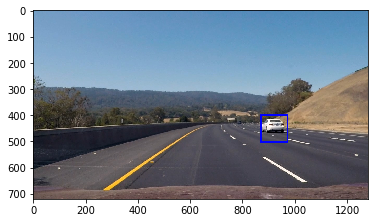

In [98]:
%matplotlib inline
test_images = glob.glob('test_images/*.jpg')
# switch to plt.imread method to avoid color conversion confusion
test_image = plt.imread(test_images[2])
# search only the bottom part of the figure
ystart, ystop = 400, 656
# try different scales to see how well they perform in detecting vehicles
scale = 1.
out_image, box_list = find_cars(test_image, ystart, ystop, scale, clf, 
                      X_scaler, orient, pix_per_cell, cell_per_block, 
                      spatial_size =(spatial, spatial), hist_bins = histbins)
plt.imshow(out_image)

In [105]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, box_list):
    # Iterate over box list
    for box in box_list:
        # Add 1 to every pixel within the box
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

# Set a threshold to reject false detections
def heat_threshold(heatmap, threshold):
    # zero out pixels below the threshold 
    heatmap[heatmap<=threshold] = 0
    return heatmap

# Create a list of scales for different search window sizes
scales = [0.8, 1.0, 1.2, 1.4, 1.5, 1.6, 1.8, 2, 2.25, 2.5]
box_lists = []
test_image = plt.imread(test_images[4])
for scale in scales:
    out_image, box_list = find_cars(test_image, ystart, ystop, scale, clf, 
                                    X_scaler, orient, pix_per_cell, cell_per_block, 
                                    spatial_size =(spatial, spatial), hist_bins = histbins)
    box_lists.extend(box_list)
    

C:\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


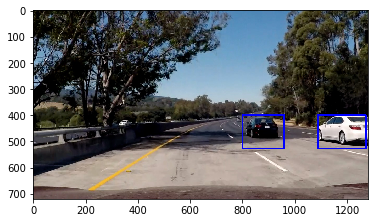

In [111]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_image = np.copy(img)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_image

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_lists)
heat = heat_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_image = draw_labeled_bboxes(test_image, labels)
#plt.imshow(heatmap, cmap = 'hot')
plt.imshow(draw_image)

C:\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


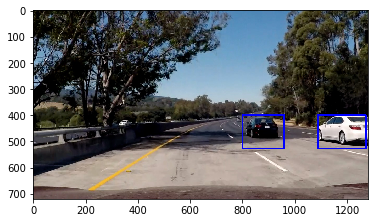

In [112]:
# Define a pipeline function to process the image
def pipeline(img):
    # define parametes
    spatial = 32
    histbins = 32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    scales = [0.8, 1.0, 1.2, 1.4, 1.5, 1.6, 1.8, 2, 2.25, 2.5]
    box_lists = []
    for scale in scales:
        out_image, box_list = find_cars(img, ystart, ystop, scale, clf, 
                                        X_scaler, orient, pix_per_cell, cell_per_block, 
                                        spatial_size =(spatial, spatial), hist_bins = histbins)
        box_lists.extend(box_list)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_lists)
    heat = heat_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(img, labels)
    return draw_image

test_image = plt.imread(test_images[4])
draw_image = pipeline(test_image)
plt.imshow(draw_image)

In [113]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [116]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████▉| 1260/1261 [47:12:37<02:47, 167.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 1d 23h 12min 39s


In [117]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [120]:
import pickle
parameter = {'scaler':X_scaler, 'classifer':clf}
with open("parameter.obj", "wb")as f:
    pickle.dump(parameter, f)